# Current Amplifier Output Calibration

This script converts current_output_cal_functions into the OutputChannel() class for easier re-use (to cal Channel U and Channel V). Hopefully this serves as a starting point for my calibration routines, making them easier to convert to python-tcal

In [1]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import os
import pyvisa as visa
from pathlib import Path
from scipy.interpolate import interp1d

from saveCalData import saveMeasurement

In [2]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [4]:
## How to make use of update_progress()
number_of_elements = 25

for i in range(number_of_elements):
    time.sleep(0.1) #Replace this with a real computation
    update_progress(i / number_of_elements)

update_progress(1)

Progress: [####################] 100.0%


In [3]:
def serialQry(port, command):
    port.reset_input_buffer()
    port.write((command + '\n').encode('ascii'))
    return port.readline().decode('ascii').strip() #strip removes white space

def serialCmd(port, command):
    port.reset_input_buffer()
    port.write((command + '\n').encode('ascii'))

In [4]:
def rms(x):
    return np.sqrt(np.mean(x**2))

In [5]:
sr542 = serial.Serial(port='COM11', baudrate=115200, timeout=.5)
cs580 = serial.Serial(port='COM10', baudrate=9600, timeout=0.5)
rm = visa.ResourceManager()
rm.list_resources()
dvm = rm.open_resource('USB0::0x0957::0xB318::MY52449038::INSTR')

In [6]:
print(serialQry(sr542, '*IDN?'))
print(serialQry(cs580, '*IDN?'))
print(dvm.query('*IDN?'))

Stanford_Research_Systems, SR542, s/n00001007, v0.10
Stanford_Research_Systems,CS580,s/n137132,ver1.14
Agilent Technologies,34450A,MY52449038,00.56-00.63



# Define Cal Functions

In [9]:
class OutputChannel():
    def __init__(self, channel):
        if channel == 'U' or channel == 'V':
            self.channel = channel
        else:
            raise ValueError('Invalid channel assignment')
        
        # Default all values to ideal or nominal
        self.R = 0.1 # ohms
        self.Vref = 3.3 # volts
        self.dacBits = 12
        self.numCodes = 2**self.dacBits
        self.R_f = 10e3 # ohms
        self.R_in = 90.9e3 # ohms
        self.R_sense_nom = 0.1 # ohms
        self.HowlandGain = self.R_f/(self.R_in*self.R_sense_nom)
        self.LSB_A = self.Vref/self.numCodes*self.HowlandGain # LSB size, in Amps
        self.LUT = np.arange(0, self.numCodes, 1) # The Correction LUT
        self.idealCurrent = np.poly1d([self.Vref/self.numCodes, -self.Vref/2])*self.HowlandGain # linear current output defined by [slope, offset]
        self.allCodes = self.LUT
        self.txFun = self.idealCurrent(self.allCodes) # The Measured Transfer Function: txFun[code] = output (A)
        self.cald = False
        self.passed = False
        
    def SweepI_MeasV(self, I_init, I_final, I_step):

        I_sweep = np.arange(I_init, I_final + I_step, I_step)

        serialCmd(cs580, 'GAIN G50mA')
        serialCmd(cs580, f'CURR {I_init:.3f}')
        serialCmd(cs580, 'INPT OFF')
        serialCmd(cs580, 'SOUT ON')

        time.sleep(1.0)
        V_meas = []

        for curr in I_sweep:
            serialCmd(cs580, f'CURR {curr:.3f}')
            time.sleep(1.0)
            V_meas.append(float(dvm.query('MEAS:VOLT:DC? 0.1, 3e-5').strip('\n')))

        serialCmd(cs580, 'CURR 0')
        serialCmd(cs580, 'SOUT OFF')

        coeffs, cov = np.polyfit(I_sweep, V_meas, 1, cov=True)
        fit = np.poly1d(coeffs)
        R_meas = coeffs[0]
        R_std = np.sqrt(np.diag(cov))[0]
        print(f'R = {R_meas:.5e} +- {R_std:.5e} Ohms')
        self.R = R_meas

        plt.plot(I_sweep, V_meas, '.')
        plt.plot(I_sweep, fit(I_sweep), label=f'fit: R={coeffs[0]:.6} Ohms')
        plt.xlabel('applied current (A)')
        plt.ylabel('meas voltage (V)')
        plt.legend()   
        plt.title('4 pt I-V Resistance Measurement')

    def MeasVoltageVsDacCode(self, codes):
        serialCmd(sr542, '$CEN ON')
        time.sleep(30.0)

        t0 = time.time()

        V_sense = []
        for dacCode in codes:
            if(self.channel=='U'):
                serialCmd(sr542, f'$SUV {dacCode}, 2048')
            elif(self.channel=='V'):
                serialCmd(sr542, f'$SUV 2048, {dacCode}')
            else:
                print('Invalid Channel')
                break

            time.sleep(0.1) #TODO: how long to sleep here?
            V = float(dvm.query('MEAS:VOLT:DC? 10, 1.5e-6')) #voltage measured across ~R_sense
            #print(f'{dacCode}, {V}')
            V_sense.append(V) 

            update_progress(len(V_sense) / len(codes))

        serialCmd(sr542, '$SUV 2048, 2048')
        serialCmd(sr542, '$CEN OFF')

        print(f'elapsed time = {time.time() - t0}')

        return np.array(V_sense)

    def PlotCurrentError(self, codes, V_meas):    
        def CurrentToLsb(I_A):
            return I_A/self.LSB_A

        def LsbToCurrent(bits):
            return bits*self.LSB_A

        I_A = V_meas/self.R
        I_A_error = I_A - self.idealCurrent(codes)
        I_c_error = I_A_error/self.LSB_A

        minor_ticks = np.arange(int(min(I_c_error)), int(max(I_c_error)) + 1, 1)

        fig, axL = plt.subplots(figsize=(8,8))
        axL.plot(codes, I_c_error, '.', label='measured error')
        if self.cald:
            axL.plot(self.allCodes, (self.txFun[self.LUT[self.allCodes]] - self.idealCurrent(self.allCodes))/self.LSB_A, 
                     label='expected error')        
        axL.set_xlabel('dac code')
        axL.set_ylabel('output error (LSBs)')    
        axL.set_yticks(minor_ticks, minor=True)
        axL.grid('y')
        axL.grid('y', which='minor', alpha=0.5)
        axL.set_title(f'Channel {self.channel} Output Error')
        axL.legend()

        axR = axL.secondary_yaxis('right', functions=(LsbToCurrent, CurrentToLsb))
        axR.grid(axis='y')
        axR.set_ylabel('output error (A)')
        
    def CreateLUT(self, dacCodes, V_meas):
        I_A = V_meas/self.R
        cubicSpline = interp1d(dacCodes, I_A, kind='cubic')
                
        error_A = cubicSpline(self.allCodes) - self.idealCurrent(self.allCodes)
        error_c = error_A/LSB_A # error in number of LSBs (or codes)        

        self.LUT = np.rint(np.clip(allCodes - error_c, 0, 4095)).astype(np.int16)           
        self.txFun = cubicSpline(allCodes)
        self.cald = True

        return error_c

    def ApplyLUTCorrection(self):
        plt.figure(figsize=(8,8))
        
        plt.plot(self.allCodes, (self.txFun[self.allCodes] - self.idealCurrent(self.allCodes))/self.LSB_A, '.', label='uncal')
        plt.plot(self.allCodes, (self.txFun[self.LUT[self.allCodes]] - self.idealCurrent(self.allCodes))/self.LSB_A, label='LUT correction')        
        plt.grid(axis='y')
        plt.xlabel('dac code')
        plt.ylabel('output error (LSBs)')
        plt.legend()
        plt.title('Expected Calibrated Output Error')
        
    def EvaluatePassFail(self, dacCodes, V_meas):
        error_A = V_meas/self.R - idealCurrent(dacCodes)
        
        rms_error_LSB = rms(error_A/self.LSB_A)       
            
        print(f'rms error = {rms(error_A/self.LSB_A):.3f} LSBs')
        
        if rms_error_LSB < 3: # TODO: what to set this to?
            self.passed = True
            print('Calibration Passed!')
        else:
            self.passed = False
            print('Calibration Failed')
            
        return self.passed
            
    def UploadCalData(self):
        t0 = time.time()
        for i, calCode in enumerate(self.LUT):
            if self.channel=='U':
                serialCmd(sr542, f'$DAC CHU, {i}, {calCode}')                
            elif self.channel=='V':
                serialCmd(sr542, f'$DAC CHV, {i}, {calCode}')
            else:
                raise ValueError('Invalid Channel')
                break
                
            time.sleep(.05)
    
            update_progress(i / len(self.LUT))
        
        print(f'elapsed time = {time.time() - t0}')
            
    def SaveCalData(self):
        controllerSn = serialQry(sr542, '*IDN?').split(',')[2].strip(' s/n')
        saveMeasurement('.\CalData', controllerSn, f'Ch{self.channel}_outputCal', self.LUT, ['dac code'], fmt='%d')

# Perform The Calibration

R = 9.92845e-02 +- 1.37608e-05 Ohms


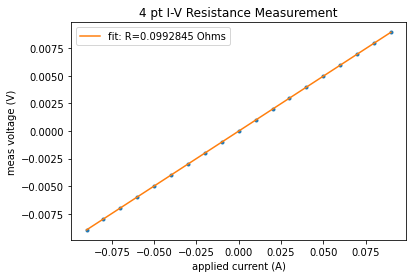

In [210]:
ChV = OutputChannel('V')
ChV.SweepI_MeasV(-90e-3, 90e-3, 10e-3)

Progress: [####################] 100.0%
elapsed time = 122.59585881233215


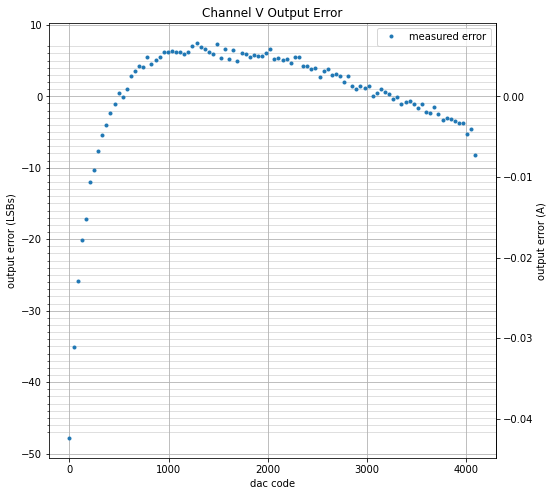

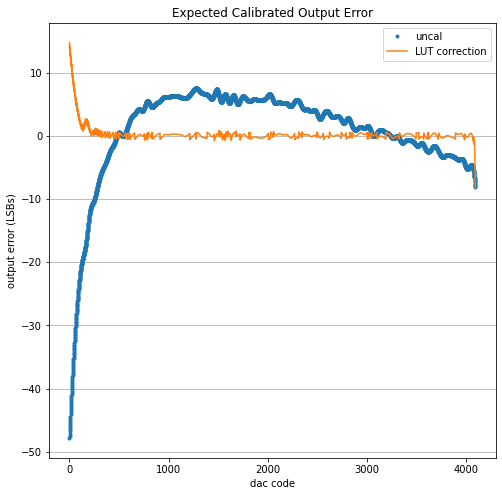

In [211]:
testCodes = np.linspace(0, numCodes-1, 100, dtype=int)
V_V = ChV.MeasVoltageVsDacCode(testCodes)
ChV.PlotCurrentError(testCodes, V_V)

ChV.CreateLUT(testCodes, V_V)
ChV.ApplyLUTCorrection()

# Experimental Verification of the Calibration

Progress: [####################] 100.0%
elapsed time = 126.28286409378052


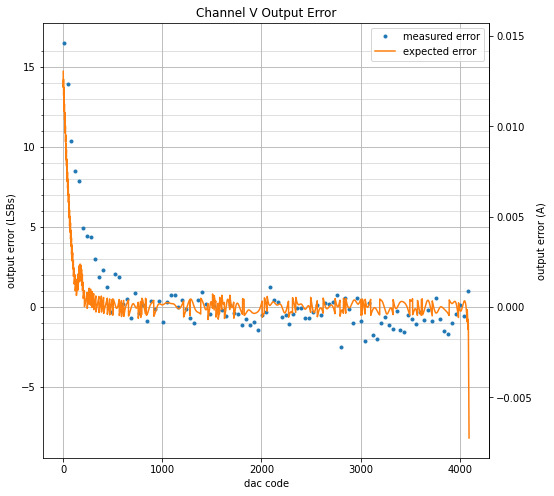

In [212]:
verifyCodes = np.arange(3, numCodes-1, 40, dtype=int)
V_V_corrected = ChV.MeasVoltageVsDacCode(ChV.LUT[verifyCodes])
ChV.PlotCurrentError(verifyCodes, V_V_corrected)

In [213]:
if ChV.EvaluatePassFail(verifyCodes, V_V_corrected):
    ChV.SaveCalData()

rms error = 2.891 LSBs
Calibration Passed!


## Upload LUTs to SR542

In [219]:
# Query LUT for Channel V, element 3
serialQry(sr542, '$DAC? CHV, 2048')

'2042'

In [220]:
ChV.LUT[2048]

2042

In [217]:
ChV.UploadCalData()

elapsed time = 258.52245807647705


## Repeat the entire Cal Process for Channel U

R = 9.92875e-02 +- 9.46816e-06 Ohms


NameError: name 'testCodes' is not defined

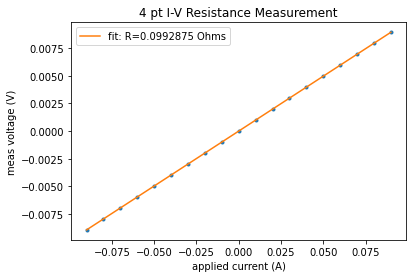

In [13]:
ChU = OutputChannel('U')
ChU.SweepI_MeasV(-90e-3, 90e-3, 10e-3)

Progress: [####################] 100.0%
elapsed time = 122.54567837715149


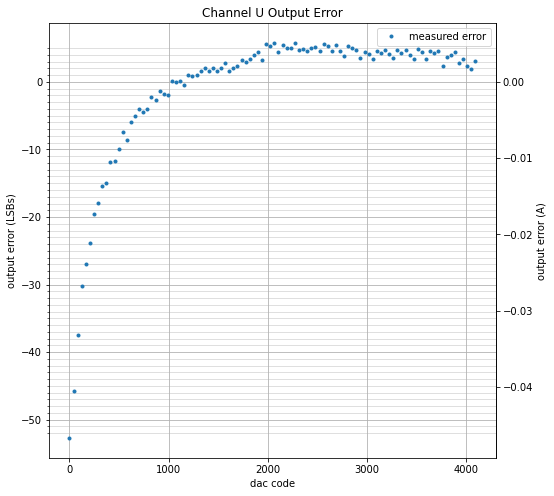

In [15]:
testCodes = np.linspace(0, ChU.numCodes-1, 100, dtype=int)
V_U_upSweep = ChU.MeasVoltageVsDacCode(testCodes)
ChU.PlotCurrentError(testCodes, V_U_upSweep)

Progress: [####################] 100.0%
elapsed time = 122.70404863357544


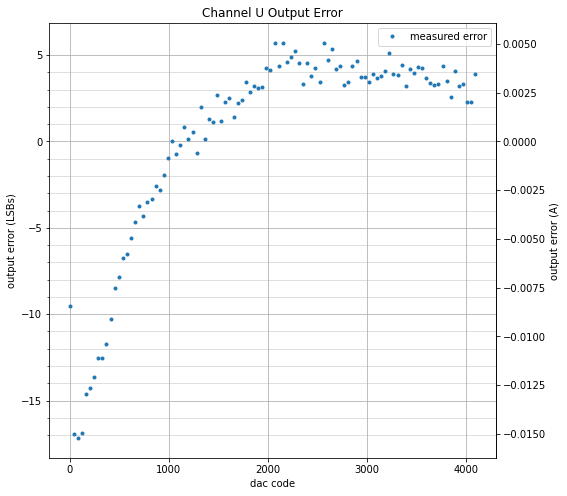

In [16]:
V_U_dnSweep = ChU.MeasVoltageVsDacCode(np.flip(testCodes))
ChU.PlotCurrentError(testCodes, np.flip(V_U_dnSweep))

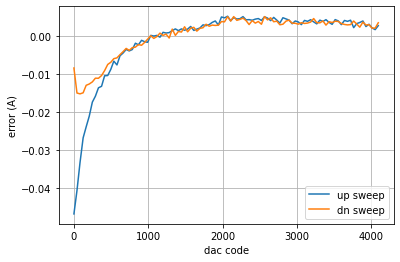

In [27]:
plt.plot(testCodes, V_U_upSweep/ChU.R - ChU.idealCurrent(testCodes), label='up sweep')
plt.plot(testCodes, np.flip(V_U_dnSweep)/ChU.R - ChU.idealCurrent(testCodes), label='dn sweep')
plt.legend()
plt.xlabel('dac code')
plt.ylabel('error (A)')
plt.grid()

Progress: [####################] 100.0%
elapsed time = 258.05478072166443


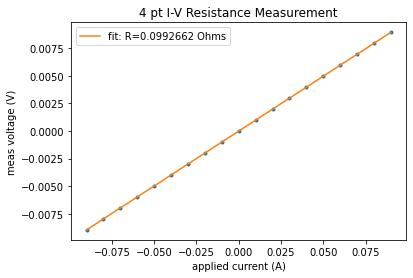

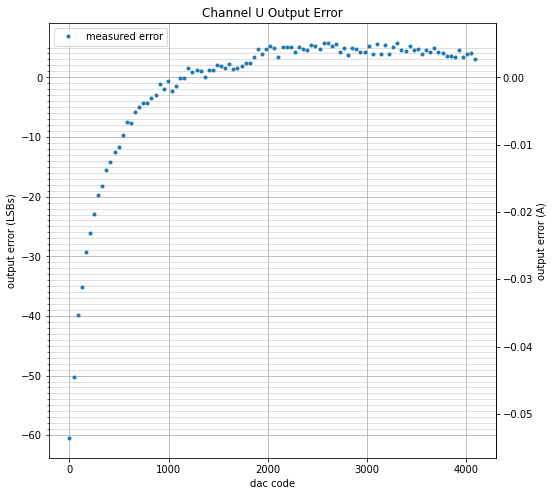

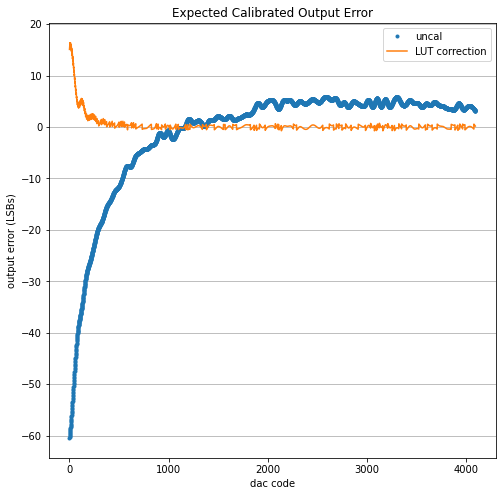

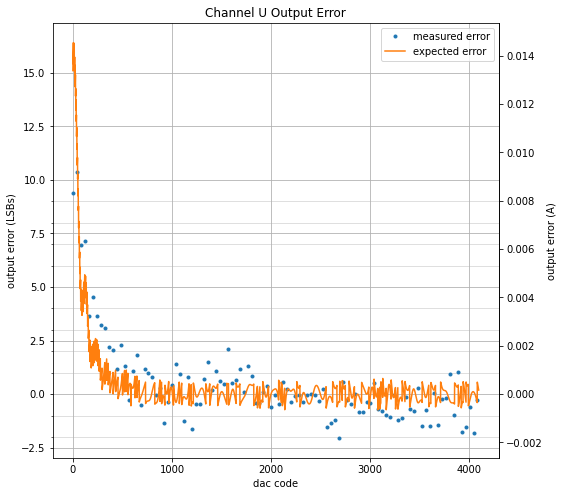

In [223]:
ChU = OutputChannel('U')
ChU.SweepI_MeasV(-90e-3, 90e-3, 10e-3)

testCodes = np.linspace(0, numCodes-1, 100, dtype=int)
V_U = ChU.MeasVoltageVsDacCode(testCodes)
ChU.PlotCurrentError(testCodes, V_U)

ChU.CreateLUT(testCodes, V_U)
ChU.ApplyLUTCorrection()

verifyCodes = np.arange(3, numCodes-1, 40, dtype=int)
V_U_corrected = ChU.MeasVoltageVsDacCode(ChU.LUT[verifyCodes])
ChU.PlotCurrentError(verifyCodes, V_U_corrected)

if ChU.EvaluatePassFail(verifyCodes, V_U_corrected):
    ChU.SaveCalData()
    ChU.UploadCalData()

In [224]:
ChU.EvaluatePassFail(verifyCodes, V_U_corrected)

rms error = 2.095 LSBs
Calibration Passed!


True

In [225]:
ChU.LUT

array([  60,   61,   62, ..., 4090, 4091, 4092], dtype=int16)

In [228]:
ChU.txFun/ChU.LSB_A + 2048

array([ -60.4744207 ,  -59.30845557,  -58.13647507, ..., 4096.15959414,
       4097.13029405, 4098.10068387])

In [229]:
ChU.idealCurrent(ChU.allCodes)

array([-1.81518152, -1.8142952 , -1.81340888, ...,  1.81252256,
        1.81340888,  1.8142952 ])

In [232]:
(ChU.txFun - ChU.idealCurrent(ChU.allCodes))/LSB_A

array([-60.4744207 , -60.30845557, -60.13647507, ...,   3.15959414,
         3.13029405,   3.10068387])

## Verify the uploaded LUTs

In [68]:
numCodes

4096

In [89]:
# Define the measurement sweep
verifyCodes = np.linspace(3, numCodes-1, 200, dtype=int)

#V_U_cal = MeasCurrVsDacCode(verifyCodes, channel='U')
V_V_cal = MeasCurrVsDacCode(verifyCodes, channel='V')

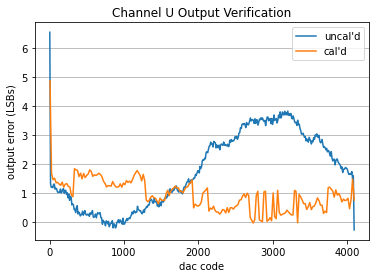

In [71]:
plt.plot(testCodes, (V_U/R_U_ohms - idealCurrent(testCodes))/LSB_A, label="uncal'd")
plt.plot(verifyCodes, (V_U_cal/R_U_ohms - idealCurrent(verifyCodes))/LSB_A, label="cal'd")
plt.xlabel('dac code')
plt.ylabel('output error (LSBs)')
plt.grid(axis='y')
plt.title('Channel U Output Verification')
plt.legend()

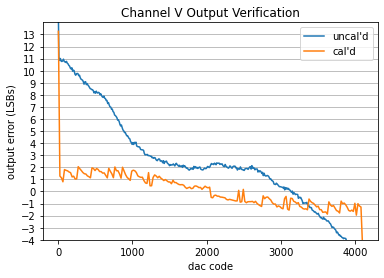

In [93]:
plt.plot(testCodes, (V_V/R_V_ohms - idealCurrent(testCodes))/LSB_A, label="uncal'd")
plt.plot(verifyCodes, (V_V_cal/R_V_ohms - idealCurrent(verifyCodes))/LSB_A, label="cal'd")
plt.xlabel('dac code')
plt.ylabel('output error (LSBs)')
plt.grid(axis='y')
plt.ylim(-4, 14)
plt.yticks(np.arange(-4, 14, 1))
plt.title('Channel V Output Verification')
plt.legend()

In [143]:
# Test repeatability
numTrials = 3

V = []
for i in range(numTrials):
    V.append(MeasCurrVsDacCode(testCodes, channel='V'))

In [145]:
len(V)

3

Text(0, 0.5, 'error (A)')

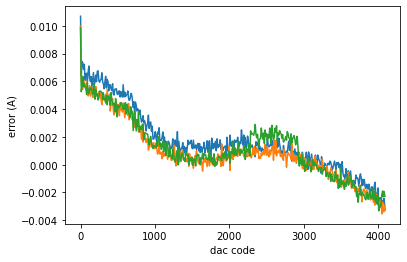

In [150]:
for trial in V:
    plt.plot(testCodes, trial/R_V_ohms - idealCurrent(testCodes))
    
plt.(testCodes, np.mean(trial)
plt.xlabel('dac code')
plt.ylabel('error (A)')

In [164]:
V

[5.50211212e-05,
 5.5127799e-05,
 7.79493369e-05,
 5.16895679e-05,
 5.03702986e-05,
 1.49652702e-06,
 1.1444711e-05,
 5.54975011e-05,
 5.97739957e-05,
 3.56883912e-06,
 5.39347753e-05,
 5.07380678e-05,
 1.6882087e-05,
 8.04533295e-06,
 5.05084238e-05,
 1.63402714e-05,
 4.82412162e-05,
 -2.0018877e-05,
 4.16858949e-05,
 6.19310941e-05,
 6.33651419e-05,
 6.15812855e-05,
 2.16992244e-05,
 7.58437965e-05,
 1.26428383e-05,
 3.50801884e-05,
 2.13911141e-05,
 3.64544036e-05,
 2.83089922e-05,
 7.4788442e-05,
 2.71407051e-05,
 8.65456057e-06]

In [168]:
V = []
for i in range(32):
    V.append(float(dvm.query('MEAS:VOLT:DC? 1, 1.5e-6')))

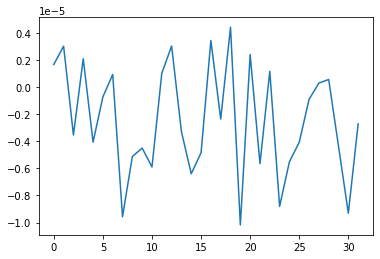

In [169]:
plt.plot(V)

In [170]:
rms(np.array(V))

4.752971072430931e-06

In [157]:
3.3/4096

0.0008056640625

In [50]:
float(serialQry(sr542, 'CURR? INST'))

-0.00141

In [63]:
codes = testCodes
channel = 'U'

serialCmd(sr542, '$CEN ON')
time.sleep(1.0)

I_mon = []
V_sense = []
for dacCode in codes:
    if(channel=='U'):
        serialCmd(sr542, f'$SUV {dacCode}, 2048')
    elif(channel=='V'):
        serialCmd(sr542, f'$SUV 2048, {dacCode}')
    else:
        print('Invalid Channel')
        break

    time.sleep(1.0)
    V = float(dvm.query('MEAS:VOLT:DC? 10, 1.5e-6')) #voltage measured across ~R_sense
    I = float(serialQry(sr542, 'CURR? INST'))
    #print(f'{dacCode}, {V}')
    I_mon.append(I)
    V_sense.append(V)    

serialCmd(sr542, '$SUV 2048, 2048')
serialCmd(sr542, '$CEN OFF')

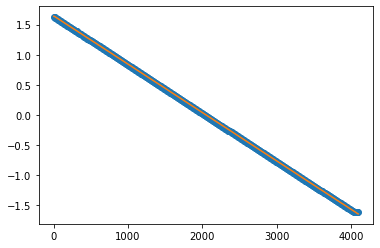

In [76]:
plt.plot(codes, -np.array(I_mon), 'o')
plt.plot(codes, np.array(V_sense)/R_W_ohms)

[0.99977609 0.01493791]


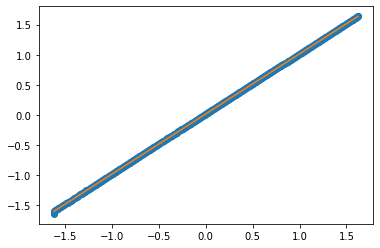

In [90]:
coeffs = np.polyfit(-np.array(I_mon), np.array(V_sense)/0.1, 1)
fit = np.poly1d(coeffs)
print(coeffs)
plt.plot(-np.array(I_mon), np.array(V_sense)/0.1, 'o')
plt.plot(-np.array(I_mon), fit(-np.array(I_mon)))

In [18]:
serialCmd(sr542, '$CEN ON')

In [23]:
serialCmd(sr542, f'$SUV 2048, 2048')

In [24]:
serialCmd(sr542, '$CEN OFF')